## 1.Import libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
import pandas_profiling as pp

# models
from sklearn.linear_model import LinearRegression, SGDRegressor, RidgeCV
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
import sklearn.model_selection
from sklearn.model_selection import cross_val_predict as cvp
from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import xgboost as xgb
import lightgbm as lgb

# model tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval

import warnings
warnings.filterwarnings("ignore")

##2.Prepare dataset

In [ ]:
cd /content/drive/My Drive/Colab Notebooks/projects/

/content/drive/My Drive/Colab Notebooks/projects


In [ ]:
kbb = pd.read_csv('kbb6.csv') 

In [ ]:
drop_columns = ['row','car_id', 'color','dealer_id','engine', 'interiorSeats','listingTitle', 'owners_address', 'owners_address_full', 'owners_city', 'owners_name', 'owners_zip', 'trim', 'vin']
kbb = kbb.drop(columns = drop_columns)

In [ ]:
kbb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24128 entries, 0 to 24127
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Car_Type              24128 non-null  object 
 1   body_code             23668 non-null  object 
 2   car_year              24128 non-null  int64  
 3   driveType             24128 non-null  object 
 4   engine_cylinder       24063 non-null  object 
 5   engine_gas            24128 non-null  object 
 6   engine_litter         24024 non-null  object 
 7   fuelEconomy_city      24128 non-null  int64  
 8   fuelEconomy_hwy       24128 non-null  int64  
 9   listingPriorityType   24128 non-null  object 
 10  make                  24128 non-null  object 
 11  model                 24128 non-null  object 
 12  odometer              24128 non-null  int64  
 13  owners_rating_count   24128 non-null  int64  
 14  owners_rating_value   24128 non-null  float64
 15  owners_state       

In [ ]:
kbb

,Car_Type,body_code,car_year,driveType,engine_cylinder,engine_gas,engine_litter,fuelEconomy_city,fuelEconomy_hwy,listingPriorityType,make,model,odometer,owners_rating_count,owners_rating_value,owners_state,price,transmission,vhrPreview_accidents,vhrPreview_damage,vhrPreview_owner,vhrPreview_salvage
0,Used,sed,2002,All wheel drive,6-Cylinder,Gas Engine,3.0L,16,23,FEATURED,jaguar,jaguar_x-type,107837,39,3.4,WA,5999,5-Speed Automatic Transmission,NO_ACCIDENTS_REPORTED,NO_FLOOD_WATER_DAMAGE,NO_ONE_OWNER,NO_SALVAGE_TITLE
1,Used,suv,2017,2 wheel drive - front,4-Cylinder,Turbo Gas Engine,1.4L,25,33,PREMIUM,chevrolet,chevrolet_trax,16814,2131,4.9,KS,18993,6-Speed Automatic Transmission,NO_ACCIDENTS_REPORTED,NO_FLOOD_WATER_DAMAGE,NO_ONE_OWNER,NO_SALVAGE_TITLE
2,Certified,pic,2018,4 wheel drive,6-Cylinder,Flexible Fuel Engine,4.3L,17,22,PREMIUM,chevrolet,chevrolet_silverado 1500 regular cab,33599,533,4.8,OH,35900,6-Speed Automatic Transmission,ACCIDENTS_REPORTED,NO_FLOOD_WATER_DAMAGE,ONE_OWNER,NO_SALVAGE_TITLE
3,Used,sed,2016,2 wheel drive - front,4-Cylinder,Gas Engine,2.5L,27,39,PREMIUM,nissan,nissan_altima,59893,258,4.5,CA,13999,Continuously Variable Automatic Transmission,ACCIDENTS_REPORTED,NO_FLOOD_WATER_DAMAGE,ONE_OWNER,NO_SALVAGE_TITLE
4,Used,sed,2018,2 wheel drive - front,4-Cylinder,Gas Engine,2.5L,29,41,PREMIUM,toyota,toyota_camry hybrid,28254,791,4.5,MA,21526,8-Speed Automatic Transmission,NO_ACCIDENTS_REPORTED,NO_FLOOD_WATER_DAMAGE,ONE_OWNER,NO_SALVAGE_TITLE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24123,Certified,suv,2018,All wheel drive,4-Cylinder,Turbo Gas Engine,1.5L,27,33,PREMIUM,honda,honda_cr-v hybrid,42875,2624,4.8,FL,25702,Continuously Variable Automatic Transmission,NO_ACCIDENTS_REPORTED,NO_FLOOD_WATER_DAMAGE,ONE_OWNER,NO_SALVAGE_TITLE
24124,Certified,sed,2018,2 wheel drive - front,4-Cylinder,Gas Engine,2.4L,25,36,PREMIUM,hyundai,hyundai_sonata plug-in hybrid,13233,2206,4.9,CA,20000,6-Speed Automatic Transmission,ACCIDENTS_REPORTED,NO_FLOOD_WATER_DAMAGE,ONE_OWNER,NO_SALVAGE_TITLE
24125,Used,suv,2006,2 wheel drive - front,6-Cylinder,Gas Engine,3.3L,17,23,PREMIUM,toyota,toyota_highlander hybrid,177388,6038,4.9,CA,6499,5-Speed Automatic Transmission,ACCIDENTS_REPORTED,NO_FLOOD_WATER_DAMAGE,NO_ONE_OWNER,NO_SALVAGE_TITLE
24126,Used,suv,2018,All wheel drive,4-Cylinder,Gas Engine,2.5L,22,28,PREMIUM,toyota,toyota_rav4 prime,41572,2171,4.5,IL,26776,6-Speed Automatic Transmission,NO_ACCIDENTS_REPORTED,NO_FLOOD_WATER_DAMAGE,ONE_OWNER,NO_SALVAGE_TITLE


In [ ]:
# shuffle the DataFrame rows
kbb = kbb.sample(frac = 1)
data = kbb.copy()

#### Encoding categorical features

In [ ]:
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical_columns = []
features = data.columns.values.tolist()

for col in features:
    if data[col].dtype in numerics: continue
    categorical_columns.append(col)

# Encoding categorical features
for col in categorical_columns:
    if col in data.columns:
        le = LabelEncoder()
        le.fit(list(data[col].astype(str).values))
        data[col] = le.transform(list(data[col].astype(str).values))

In [ ]:
data.corr()

,Car_Type,body_code,car_year,driveType,engine_cylinder,engine_gas,engine_litter,fuelEconomy_city,fuelEconomy_hwy,listingPriorityType,make,model,odometer,owners_rating_count,owners_rating_value,owners_state,price,transmission,vhrPreview_accidents,vhrPreview_damage,vhrPreview_owner,vhrPreview_salvage
Car_Type,1.000000,-0.073795,-0.218535,-0.022301,0.096091,-0.097354,0.110996,-0.094204,-0.100812,-0.017243,-0.041413,-0.031768,0.221498,-0.127611,-0.122845,0.061796,-0.080616,-0.119199,-0.059470,-0.006869,-0.182184,0.023153
body_code,-0.073795,1.000000,0.118767,0.258986,-0.283476,0.098450,-0.325265,0.020000,-0.022452,0.014915,0.083812,0.083145,0.050126,0.046548,0.094204,0.023123,-0.194237,0.056604,-0.021075,0.004931,0.097464,-0.004427
car_year,-0.218535,0.118767,1.000000,0.089625,-0.142266,0.231064,-0.152367,0.150988,0.146851,0.101946,0.011164,0.012450,-0.726958,0.067025,-0.057736,-0.054214,0.395244,0.291622,0.179638,0.008040,0.426457,-0.019523
driveType,-0.022301,0.258986,0.089625,1.000000,0.071084,0.133429,0.042321,-0.196052,-0.279643,0.011255,0.044733,0.030259,-0.060399,-0.079567,-0.029713,0.143392,0.194402,0.058899,0.033569,0.001375,0.048238,-0.006356
engine_cylinder,0.096091,-0.283476,-0.142266,0.071084,1.000000,-0.386238,0.908908,-0.451982,-0.552703,-0.000276,-0.111943,-0.099714,0.108339,-0.095285,-0.062281,0.020337,0.397443,-0.235501,0.003784,0.002086,-0.104408,0.000500
engine_gas,-0.097354,0.098450,0.231064,0.133429,-0.386238,1.000000,-0.493803,0.089467,0.114559,0.035884,-0.178839,-0.191340,-0.230033,0.014386,-0.006058,-0.031334,0.123096,-0.027971,0.054802,-0.000373,0.125874,-0.007178
engine_litter,0.110996,-0.325265,-0.152367,0.042321,0.908908,-0.493803,1.000000,-0.427007,-0.513741,-0.010263,-0.065217,-0.056460,0.097537,-0.091090,-0.067608,0.019815,0.407327,-0.205914,0.006820,0.000004,-0.120550,-0.003370
fuelEconomy_city,-0.094204,0.020000,0.150988,-0.196052,-0.451982,0.089467,-0.427007,1.000000,0.933188,0.007768,0.117114,0.107995,-0.121955,0.084741,0.046301,-0.055037,-0.276346,0.386452,0.011324,-0.001026,0.107117,-0.003843
fuelEconomy_hwy,-0.100812,-0.022452,0.146851,-0.279643,-0.552703,0.114559,-0.513741,0.933188,1.000000,0.003693,0.083852,0.069748,-0.133276,0.100295,0.045255,-0.065681,-0.347134,0.424940,-0.002385,-0.003882,0.086459,-0.000848
listingPriorityType,-0.017243,0.014915,0.101946,0.011255,-0.000276,0.035884,-0.010263,0.007768,0.003693,1.000000,-0.015600,-0.014818,-0.069018,0.025460,-0.021803,-0.023088,0.043514,0.023872,0.029692,-0.001349,0.038092,-0.032037


In [ ]:
data

,Car_Type,body_code,car_year,driveType,engine_cylinder,engine_gas,engine_litter,fuelEconomy_city,fuelEconomy_hwy,listingPriorityType,make,model,odometer,owners_rating_count,owners_rating_value,owners_state,price,transmission,vhrPreview_accidents,vhrPreview_damage,vhrPreview_owner,vhrPreview_salvage
22500,2,4,2020,2,6,2,39,16,21,2,8,105,10838,0,0.0,32,54999,0,1,1,1,0
4577,2,6,2015,5,3,10,12,18,25,2,26,290,78938,1385,5.0,31,20000,8,1,1,0,0
23941,2,4,2018,2,5,10,24,18,23,2,13,161,42973,9143,5.0,8,41430,0,1,1,0,0
20277,2,1,2015,1,3,10,12,22,31,2,13,170,70547,0,0.0,9,21999,9,1,1,1,0
9177,2,6,2019,0,3,10,4,27,33,2,16,192,16920,6019,4.9,8,26972,19,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10400,2,5,2017,0,3,2,13,27,36,2,16,189,88459,1080,4.7,12,19149,19,1,1,1,0
5414,2,5,2018,0,3,2,9,31,40,2,16,190,18377,310,4.0,3,21599,19,0,1,1,0
5188,0,6,2019,5,3,10,9,21,29,2,45,457,14960,2422,4.9,39,27735,14,1,1,1,0
21318,2,6,2020,5,3,10,14,22,27,2,28,305,9409,1375,4.3,35,33987,8,1,1,1,0


In [ ]:
data_y = data['price']
data_X = data.drop(['price'], axis=1)

In [ ]:
train, test, target, target_test = train_test_split(data_X, data_y, test_size=0.2, random_state=0)

## 3.Prepare for models

In [ ]:
acc_train_r2 = []
acc_test_r2 = []
acc_train_d = []
acc_test_d = []
acc_train_rmse = []
acc_test_rmse = []

In [ ]:
def acc_d(y_meas, y_pred):
    # Relative error between predicted y_pred and measured y_meas values
    return mean_absolute_error(y_meas, y_pred)*len(y_meas)/sum(abs(y_meas))

def acc_rmse(y_meas, y_pred):
    # RMSE between predicted y_pred and measured y_meas values
    return (mean_squared_error(y_meas, y_pred))**0.5

In [ ]:
def acc_boosting_model(num,model,train,test,num_iteration=0):
    # Calculation of accuracy of boosting model by different metrics
    
    global acc_train_r2, acc_test_r2, acc_train_d, acc_test_d, acc_train_rmse, acc_test_rmse
    
    if num_iteration > 0:
        ytrain = model.predict(train, num_iteration = num_iteration)  
        ytest = model.predict(test, num_iteration = num_iteration)
    else:
        ytrain = model.predict(train)  
        ytest = model.predict(test)

    print('target = ', target[:5].values)
    print('ytrain = ', ytrain[:5])

    acc_train_r2_num = round(r2_score(target, ytrain) * 100, 2)
    print('acc(r2_score) for train =', acc_train_r2_num)   
    acc_train_r2.insert(num, acc_train_r2_num)

    acc_train_d_num = round(acc_d(target, ytrain) * 100, 2)
    print('acc(relative error) for train =', acc_train_d_num)   
    acc_train_d.insert(num, acc_train_d_num)

    acc_train_rmse_num = round(acc_rmse(target, ytrain) * 100, 2)
    print('acc(rmse) for train =', acc_train_rmse_num)   
    acc_train_rmse.insert(num, acc_train_rmse_num)

    print('target_test =', target_test[:5].values)
    print('ytest =', ytest[:5])
    
    acc_test_r2_num = round(r2_score(target_test, ytest) * 100, 2)
    print('acc(r2_score) for test =', acc_test_r2_num)
    acc_test_r2.insert(num, acc_test_r2_num)
    
    acc_test_d_num = round(acc_d(target_test, ytest) * 100, 2)
    print('acc(relative error) for test =', acc_test_d_num)
    acc_test_d.insert(num, acc_test_d_num)
    
    acc_test_rmse_num = round(acc_rmse(target_test, ytest) * 100, 2)
    print('acc(rmse) for test =', acc_test_rmse_num)
    acc_test_rmse.insert(num, acc_test_rmse_num)

In [ ]:
def acc_model(num,model,train,test):
    # Calculation of accuracy of model акщь Sklearn by different metrics   
  
    global acc_train_r2, acc_test_r2, acc_train_d, acc_test_d, acc_train_rmse, acc_test_rmse
    
    ytrain = model.predict(train)  
    ytest = model.predict(test)

    print('target = ', target[:5].values)
    print('ytrain = ', ytrain[:5])

    acc_train_r2_num = round(r2_score(target, ytrain) * 100, 2)
    print('acc(r2_score) for train =', acc_train_r2_num)   
    acc_train_r2.insert(num, acc_train_r2_num)

    acc_train_d_num = round(acc_d(target, ytrain) * 100, 2)
    print('acc(relative error) for train =', acc_train_d_num)   
    acc_train_d.insert(num, acc_train_d_num)

    acc_train_rmse_num = round(acc_rmse(target, ytrain) * 100, 2)
    print('acc(rmse) for train =', acc_train_rmse_num)   
    acc_train_rmse.insert(num, acc_train_rmse_num)

    print('target_test =', target_test[:5].values)
    print('ytest =', ytest[:5])
    
    acc_test_r2_num = round(r2_score(target_test, ytest) * 100, 2)
    print('acc(r2_score) for test =', acc_test_r2_num)
    acc_test_r2.insert(num, acc_test_r2_num)
    
    acc_test_d_num = round(acc_d(target_test, ytest) * 100, 2)
    print('acc(relative error) for test =', acc_test_d_num)
    acc_test_d.insert(num, acc_test_d_num)
    
    acc_test_rmse_num = round(acc_rmse(target_test, ytest) * 100, 2)
    print('acc(rmse) for test =', acc_test_rmse_num)
    acc_test_rmse.insert(num, acc_test_rmse_num)

## 4.Tuning models

In [ ]:
# Linear Regression

linreg = LinearRegression()
linreg.fit(train, target)
acc_model(0,linreg,train,test)

target =  [23000 27499 24988 40926 29395]
ytrain =  [27163.51394958 29226.78398409 17418.0731396  44827.69683175
 34042.9996088 ]
acc(r2_score) for train = 54.14
acc(relative error) for train = 19.83
acc(rmse) for train = 1239631.55
target_test = [14990 32994 39298 18998 27999]
ytest = [18888.78896516 34623.53245296 34572.67210615  8511.90462436
 30454.68654937]
acc(r2_score) for test = 54.72
acc(relative error) for test = 19.76
acc(rmse) for test = 1228876.33


In [ ]:
# Support Vector Machines

svr = SVR()
svr.fit(train, target)
acc_model(1,svr,train,test)

target =  [23000 27499 24988 40926 29395]
ytrain =  [28553.81897544 28314.81684613 24894.89912257 27532.6389876
 26592.14541036]
acc(r2_score) for train = 2.17
acc(relative error) for train = 36.0
acc(rmse) for train = 1810612.62
target_test = [14990 32994 39298 18998 27999]
ytest = [25142.90320183 27963.15568927 28536.41237806 27824.4565122
 28425.83356216]
acc(r2_score) for test = 1.84
acc(relative error) for test = 36.07
acc(rmse) for test = 1809298.97


In [ ]:
# Linear SVR

linear_svr = LinearSVR()
linear_svr.fit(train, target)
acc_model(2,linear_svr,train,test)

target =  [23000 27499 24988 40926 29395]
ytrain =  [24630.94725451 27699.50954597  9570.29626891 46729.20195405
 30463.43524742]
acc(r2_score) for train = 48.68
acc(relative error) for train = 21.76
acc(rmse) for train = 1311362.23
target_test = [14990 32994 39298 18998 27999]
ytest = [16208.87418131 36393.02284525 41956.34220823 16229.53198577
 31474.6623809 ]
acc(r2_score) for test = 49.0
acc(relative error) for test = 21.68
acc(rmse) for test = 1304093.79


In [ ]:
# MLPRegressor

mlp = MLPRegressor()
param_grid = {'hidden_layer_sizes': [i for i in range(2,20)],
              'activation': ['relu'],
              'solver': ['adam'],
              'learning_rate': ['constant'],
              'learning_rate_init': [0.01],
              'power_t': [0.5],
              'alpha': [0.0001],
              'max_iter': [1000],
              'early_stopping': [True],
              'warm_start': [False]}
mlp_GS = GridSearchCV(mlp, param_grid=param_grid, 
                   cv=10, verbose=True, pre_dispatch='2*n_jobs')
mlp_GS.fit(train, target)
acc_model(3,mlp_GS,train,test)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed: 19.5min finished


target =  [23000 27499 24988 40926 29395]
ytrain =  [22895.6605934  29723.02045547 10687.73108826 37772.93724368
 26645.70323876]
acc(r2_score) for train = 57.4
acc(relative error) for train = 19.87
acc(rmse) for train = 1194827.04
target_test = [14990 32994 39298 18998 27999]
ytest = [18592.02819164 32632.85290293 33637.28784982 13686.20014068
 29779.05832583]
acc(r2_score) for test = 58.31
acc(relative error) for test = 19.73
acc(rmse) for test = 1179102.47


In [ ]:
# Decision Tree Regression

decision_tree = DecisionTreeRegressor()
decision_tree.fit(train, target)
acc_model(4,decision_tree,train,test)

target =  [23000 27499 24988 40926 29395]
ytrain =  [23000. 27499. 24988. 40926. 29395.]
acc(r2_score) for train = 100.0
acc(relative error) for train = 0.0
acc(rmse) for train = 7328.51
target_test = [14990 32994 39298 18998 27999]
ytest = [10950. 35398. 35900. 24483. 31990.]
acc(r2_score) for test = 83.84
acc(relative error) for test = 12.47
acc(rmse) for test = 734199.59


In [ ]:
# Random Forest

#random_forest = GridSearchCV(estimator=RandomForestRegressor(), param_grid={'n_estimators': [100, 1000]}, cv=5)
random_forest = RandomForestRegressor()
random_forest.fit(train, target)
acc_model(5,random_forest,train,test)

target =  [23000 27499 24988 40926 29395]
ytrain =  [22849.06 27435.75 23419.68 40458.35 27620.36]
acc(r2_score) for train = 98.22
acc(relative error) for train = 3.52
acc(rmse) for train = 244383.35
target_test = [14990 32994 39298 18998 27999]
ytest = [16607.81 32134.22 37006.26 25232.87 30277.54]
acc(r2_score) for test = 90.85
acc(relative error) for test = 9.34
acc(rmse) for test = 552510.49


In [ ]:
# XGBoost
xgb_clf = xgb.XGBRegressor({'objective': 'reg:squarederror'}) 
parameters = {'n_estimators': [60, 100, 120, 140], 
              'learning_rate': [0.01, 0.1],
              'max_depth': [5, 7],
              'reg_lambda': [0.5]}
xgb_reg = GridSearchCV(estimator=xgb_clf, param_grid=parameters, cv=5, n_jobs=-1).fit(train, target)
print("Best score: %0.3f" % xgb_reg.best_score_)
print("Best parameters set:", xgb_reg.best_params_)
acc_boosting_model(6,xgb_reg,train,test)

[16:21:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best score: 0.897
Best parameters set: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 140, 'reg_lambda': 0.5}
target =  [23000 27499 24988 40926 29395]
ytrain =  [23298.275 27739.092 20418.387 40889.41  28364.207]
acc(r2_score) for train = 97.76
acc(relative error) for train = 6.48
acc(rmse) for train = 273815.4
target_test = [14990 32994 39298 18998 27999]
ytest = [16098.458 34705.934 36126.49  28161.953 30325.56 ]
acc(r2_score) for test = 92.7
acc(relative error) for test = 8.82
acc(rmse) for test = 493444.55


In [ ]:
# Ridge Regressor

ridge = RidgeCV(cv=5)
ridge.fit(train, target)
acc_model(7,ridge,train,test)

target =  [23000 27499 24988 40926 29395]
ytrain =  [27159.9373736  29223.32045814 17418.49293922 44828.03204231
 34035.70235685]
acc(r2_score) for train = 54.14
acc(relative error) for train = 19.83
acc(rmse) for train = 1239650.25
target_test = [14990 32994 39298 18998 27999]
ytest = [18876.76691902 34625.18215519 34571.43579351  8514.6022544
 30450.69278294]
acc(r2_score) for test = 54.71
acc(relative error) for test = 19.76
acc(rmse) for test = 1228914.14


## 5.Model comparison

In [ ]:
models = pd.DataFrame({
    'Model': ['Linear Regression', 'Support Vector Machines', 'Linear SVR', 
              'MLPRegressor', 'Decision Tree Regressor', 'Random Forest',  'XGB', 'Ridge Regressor'],
    
    'r2_train': acc_train_r2,
    'r2_test': acc_test_r2,
    'd_train': acc_train_d,
    'd_test': acc_test_d,
    'rmse_train': acc_train_rmse,
    'rmse_test': acc_test_rmse
                     })

In [ ]:
pd.options.display.float_format = '{:,.2f}'.format

In [ ]:
print('Prediction accuracy for models by R2 criterion - r2_test')
models.sort_values(by=['r2_test', 'r2_train'], ascending=False)

Prediction accuracy for models by R2 criterion - r2_test


,Model,r2_train,r2_test,d_train,d_test,rmse_train,rmse_test
6,XGB,97.76,92.70,6.48,8.82,"273,815.40","493,444.55"
5,Random Forest,98.22,90.85,3.52,9.34,"244,383.35","552,510.49"
4,Decision Tree Regressor,100.00,83.84,0.00,12.47,"7,328.51","734,199.59"
3,MLPRegressor,57.40,58.31,19.87,19.73,"1,194,827.04","1,179,102.47"
0,Linear Regression,54.14,54.72,19.83,19.76,"1,239,631.55","1,228,876.33"
7,Ridge Regressor,54.14,54.71,19.83,19.76,"1,239,650.25","1,228,914.14"
2,Linear SVR,48.68,49.00,21.76,21.68,"1,311,362.23","1,304,093.79"
1,Support Vector Machines,2.17,1.84,36.00,36.07,"1,810,612.62","1,809,298.97"


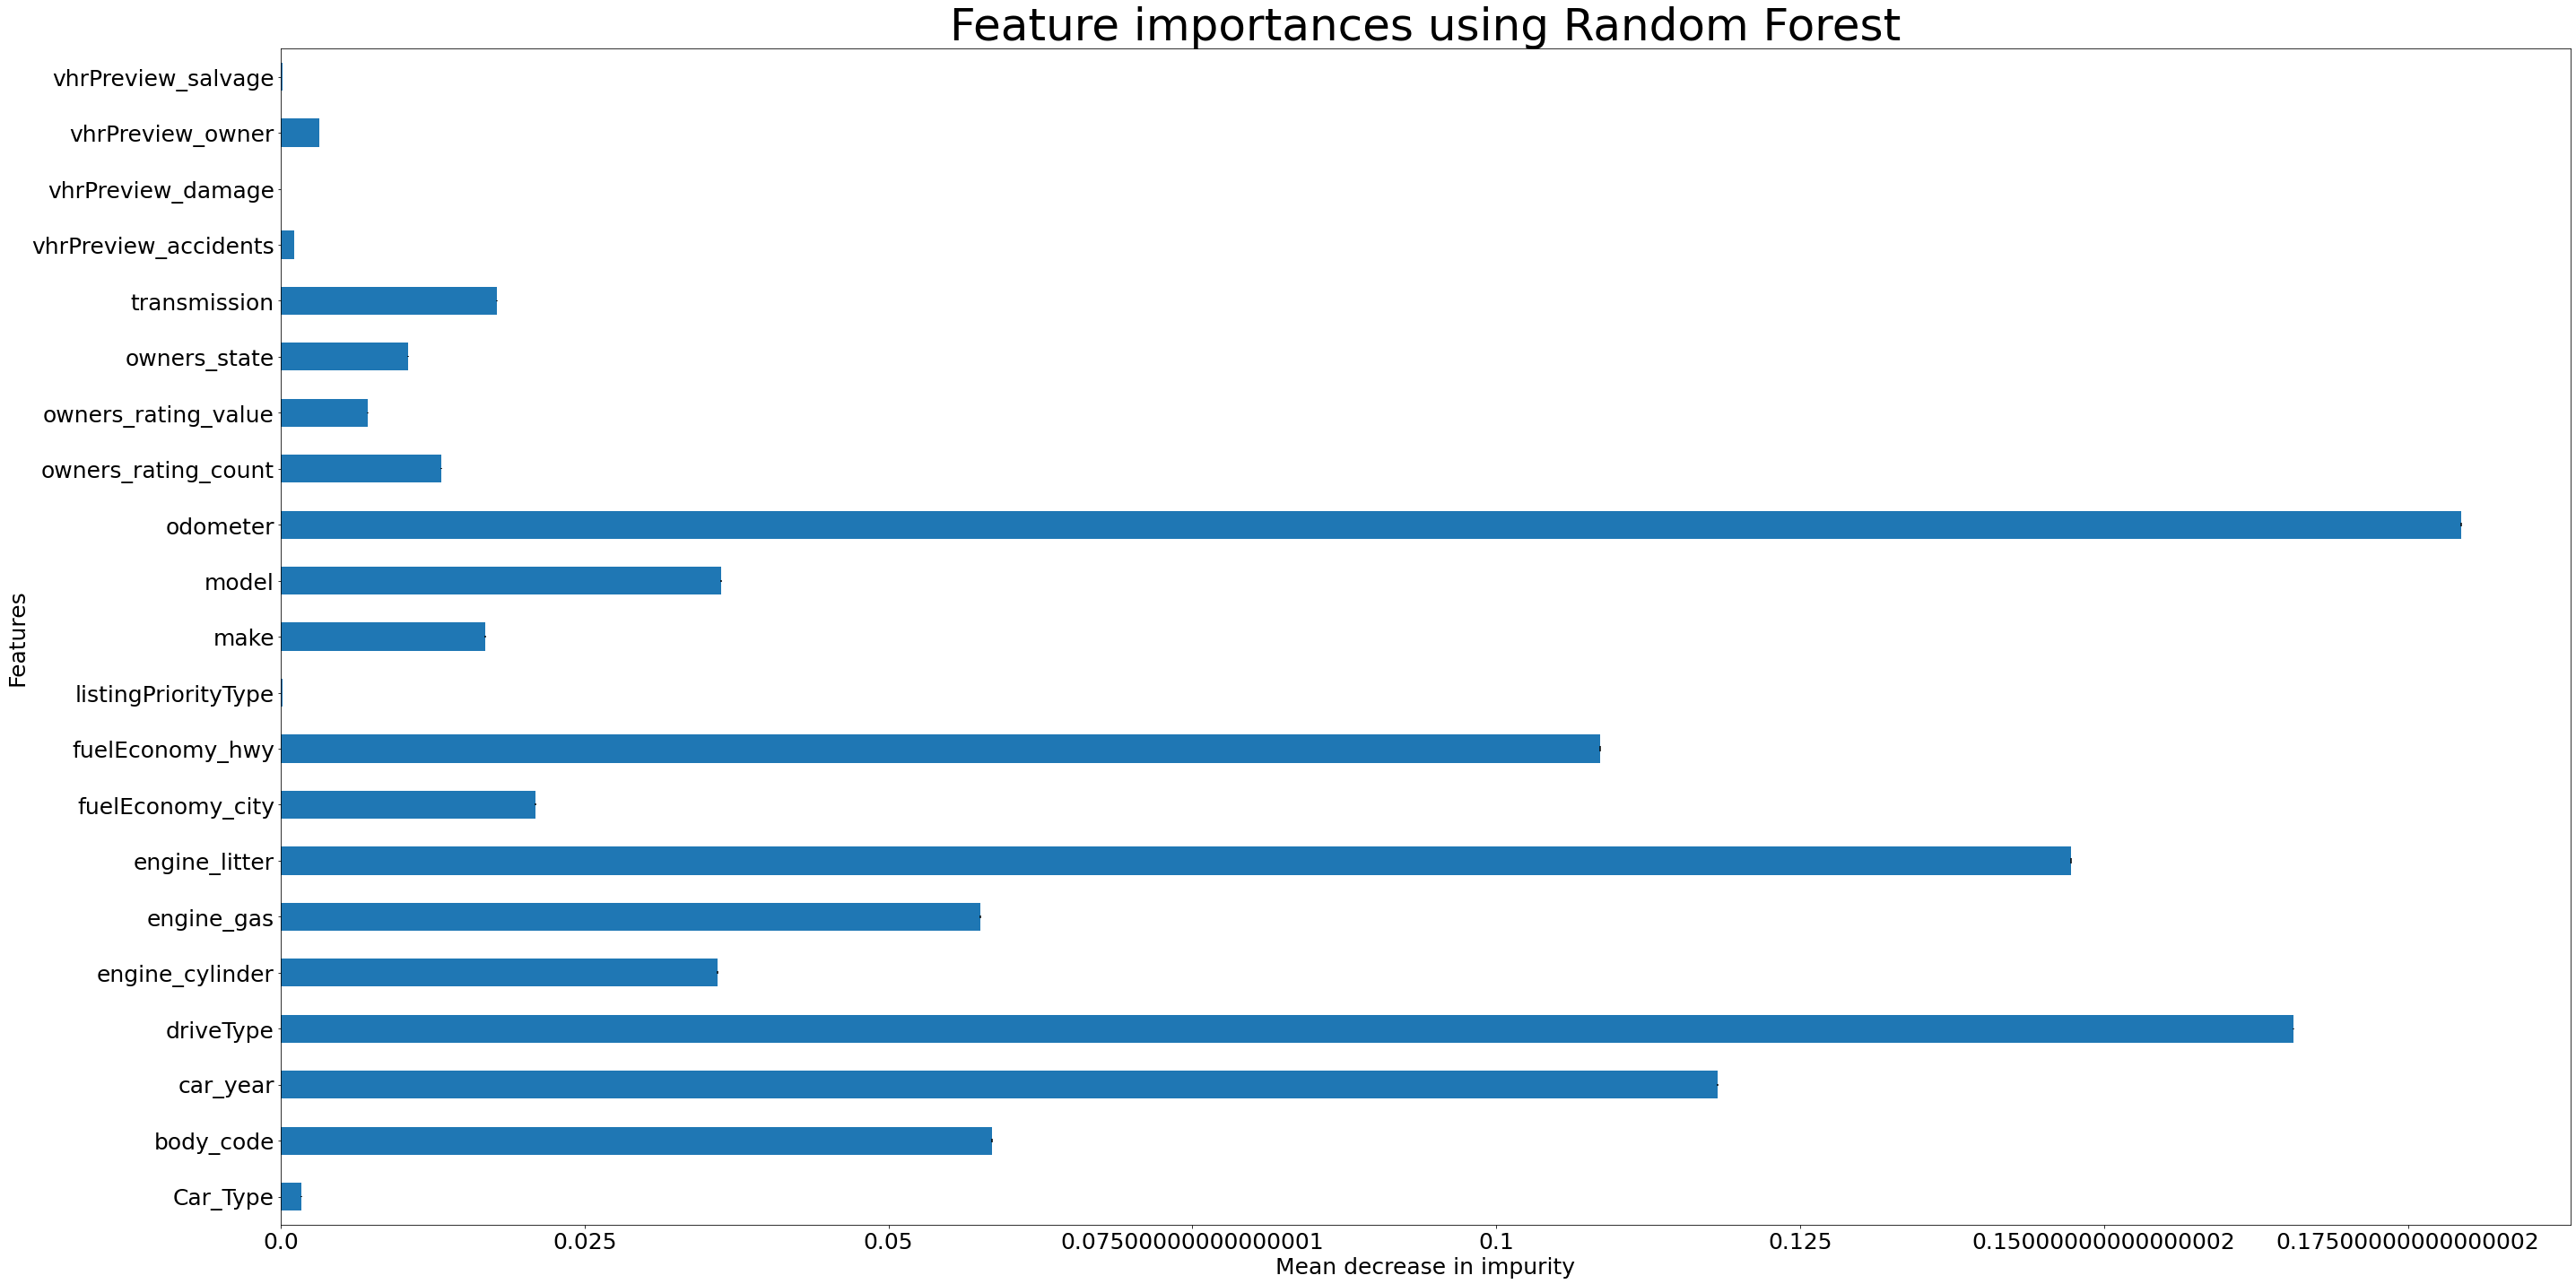

In [145]:
# Feature importance
importances = random_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in random_forest.estimators_], axis=0)

feature_names = train.columns
forest_importances = pd.Series(importances, index=feature_names)

fig = plt.figure(figsize = (40,20))
ax = fig.add_subplot(111)
forest_importances.plot.barh(yerr=std, ax=ax)
ax.set_title("Feature importances using Random Forest", size = 50)
ax.set_xlabel("Mean decrease in impurity", size = 25)
ax.set_ylabel("Features", size = 25)
ax.set_yticklabels(feature_names, size = 25)
ax.set_xticklabels(ax.get_xticks(), size = 25)
fig.tight_layout()

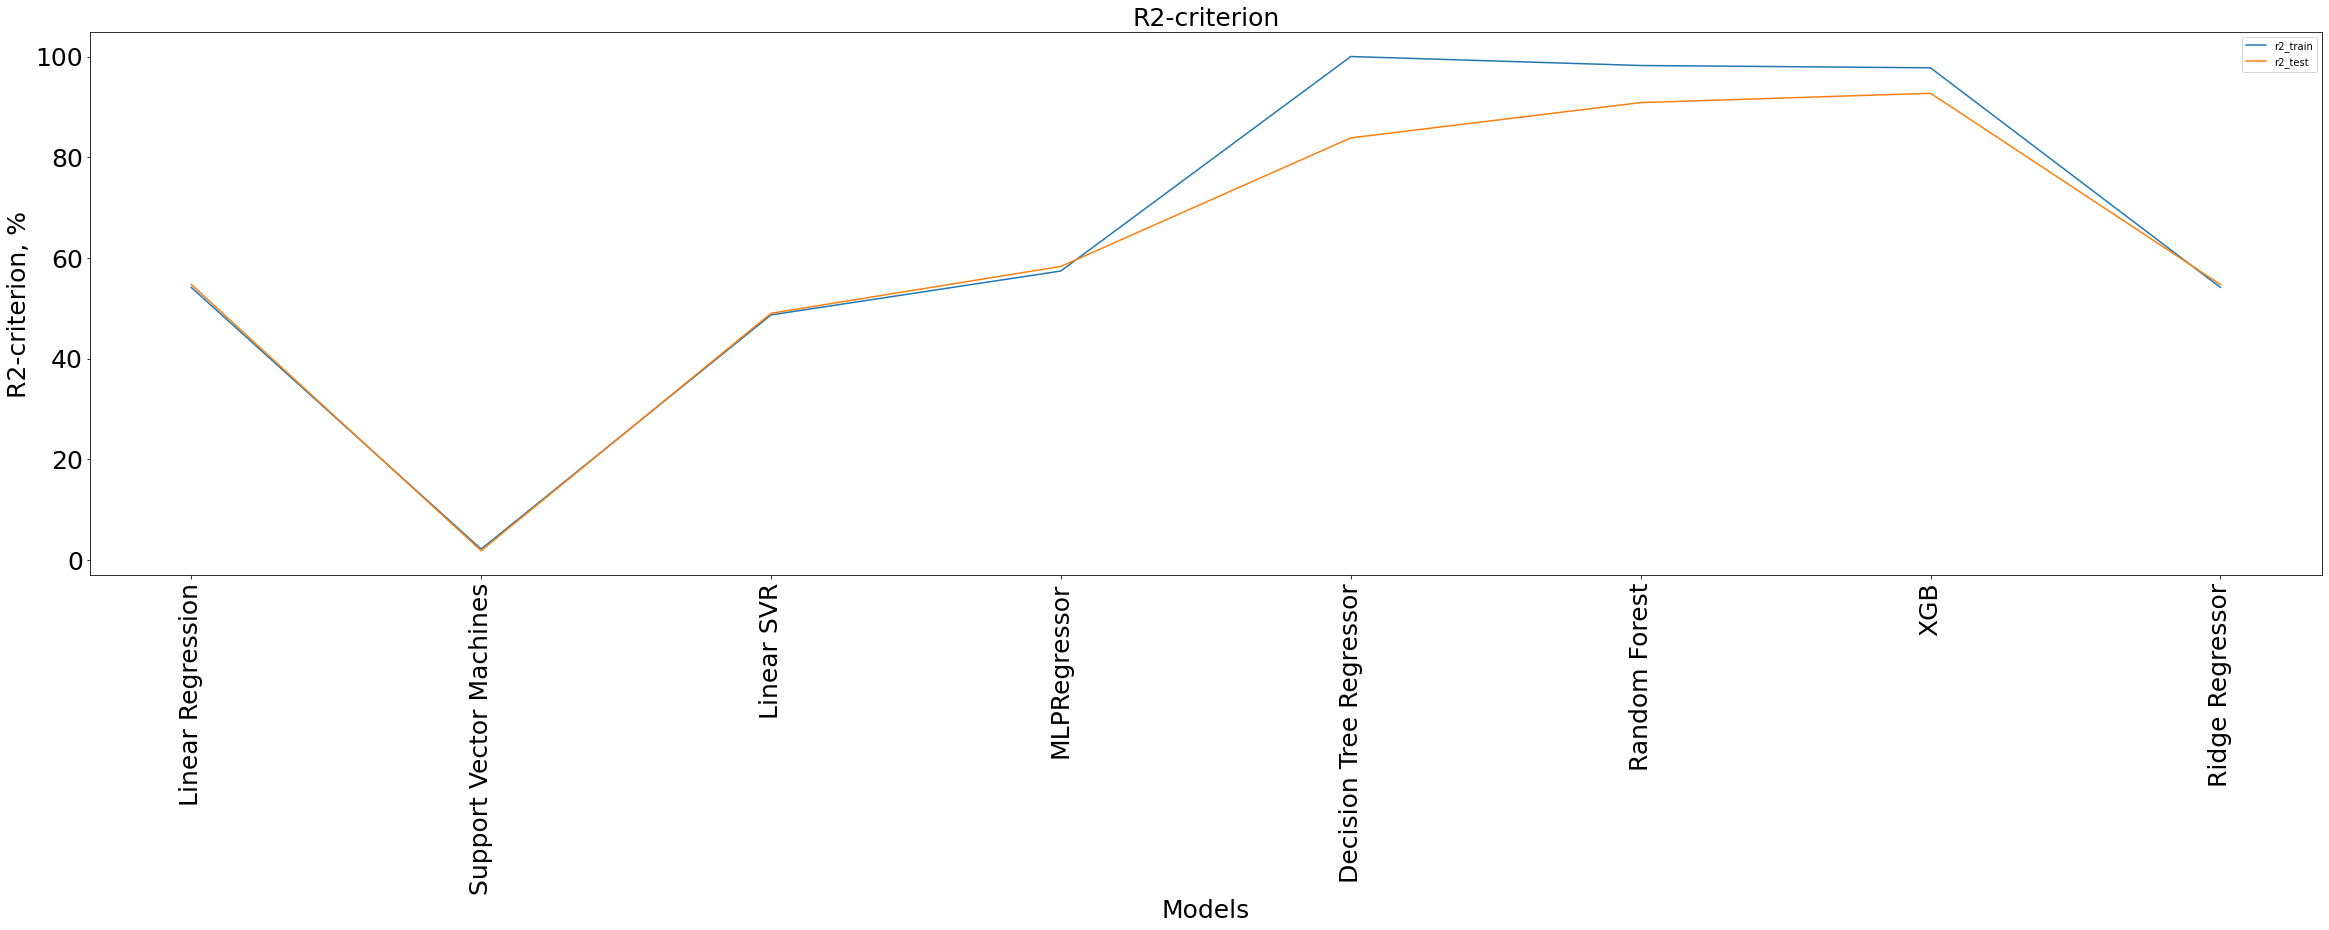

In [ ]:
# Plot
plt.figure(figsize=[40,10])
xx = models['Model']
plt.tick_params(labelsize=25)
plt.plot(xx, models['r2_train'], label = 'r2_train')
plt.plot(xx, models['r2_test'], label = 'r2_test')
plt.legend()
plt.title('R2-criterion', size = 25)
plt.xlabel('Models', size = 25)
plt.ylabel('R2-criterion, %', size = 25)
plt.xticks(xx, rotation='vertical')
plt.show()

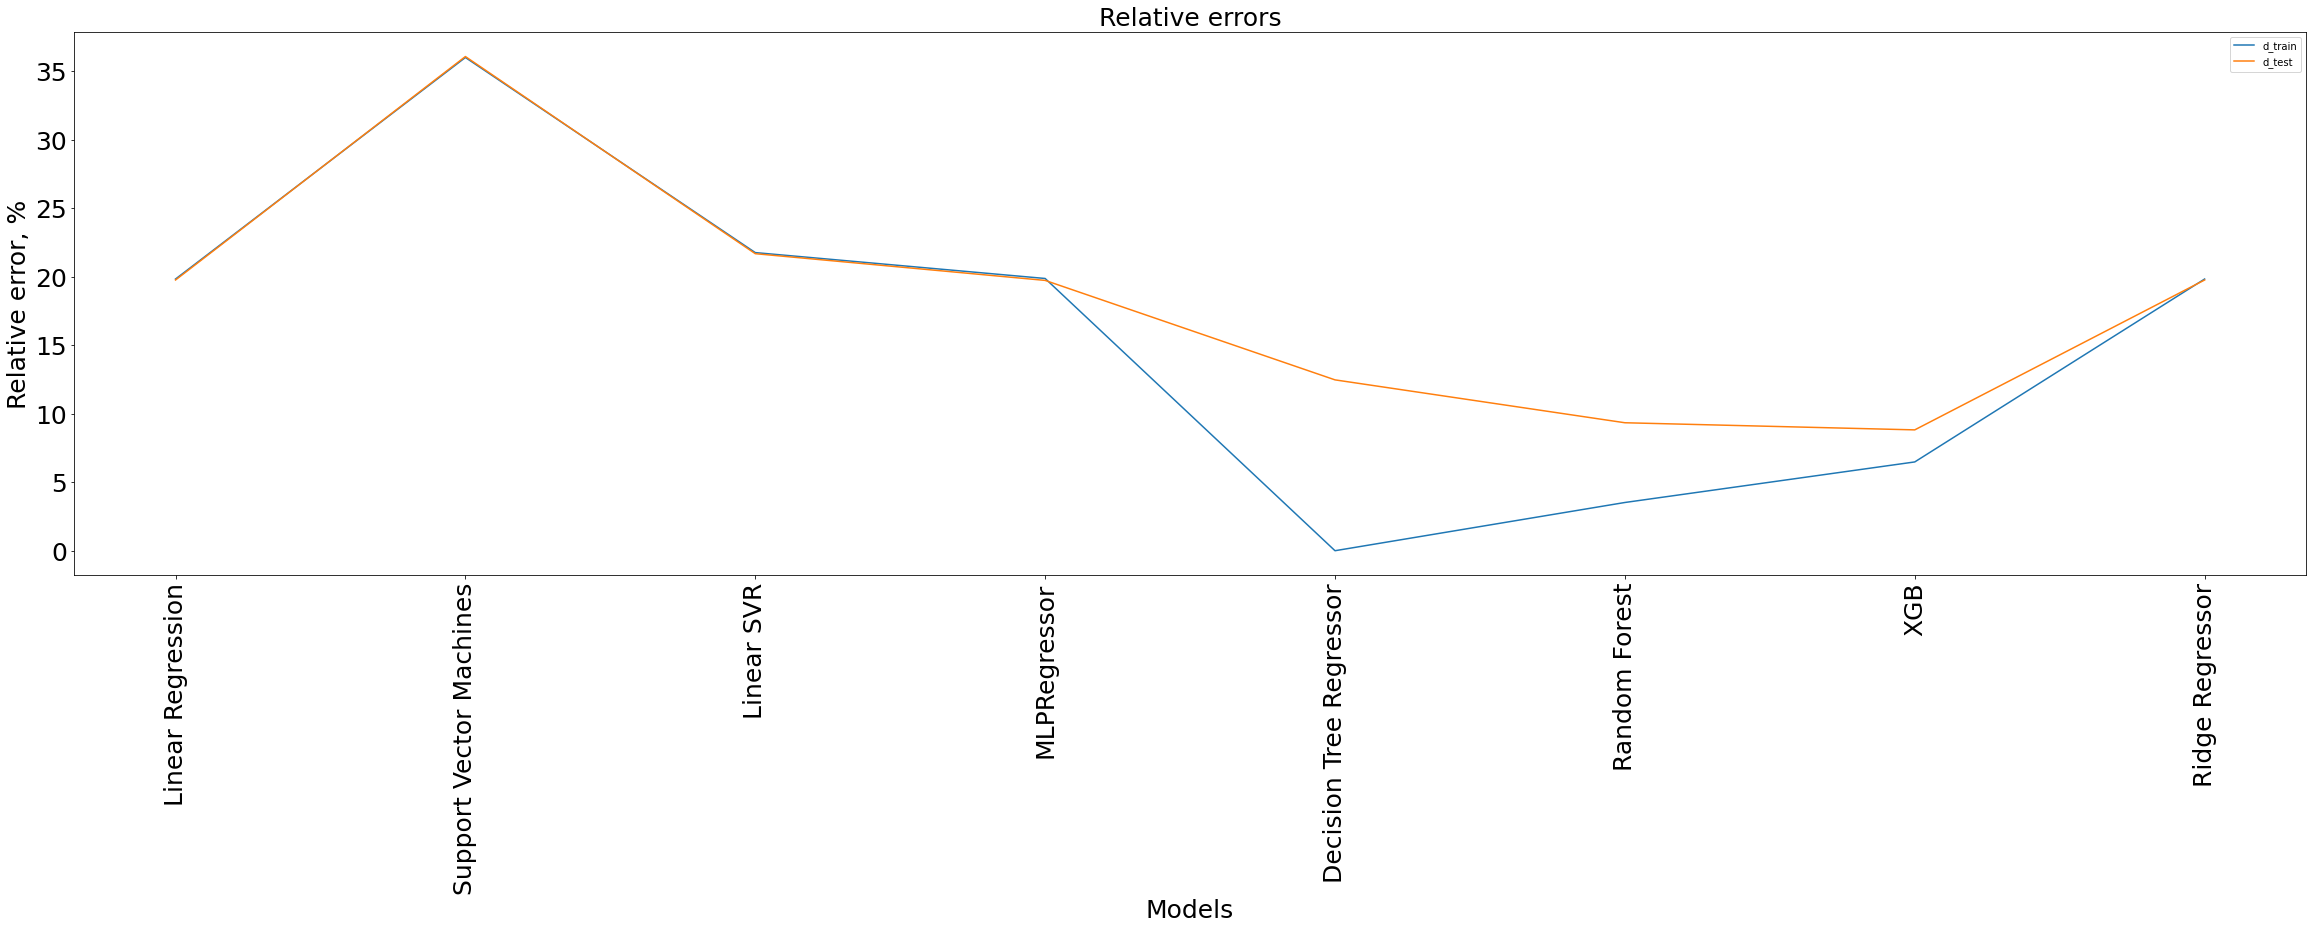

In [ ]:
# Plot
plt.figure(figsize=[40,10])
xx = models['Model']
plt.tick_params(labelsize=25)
plt.plot(xx, models['d_train'], label = 'd_train')
plt.plot(xx, models['d_test'], label = 'd_test')
plt.legend()
plt.title('Relative errors',size=25)
plt.xlabel('Models',size=25)
plt.ylabel('Relative error, %',size=25)
plt.xticks(xx, rotation='vertical')
plt.show()

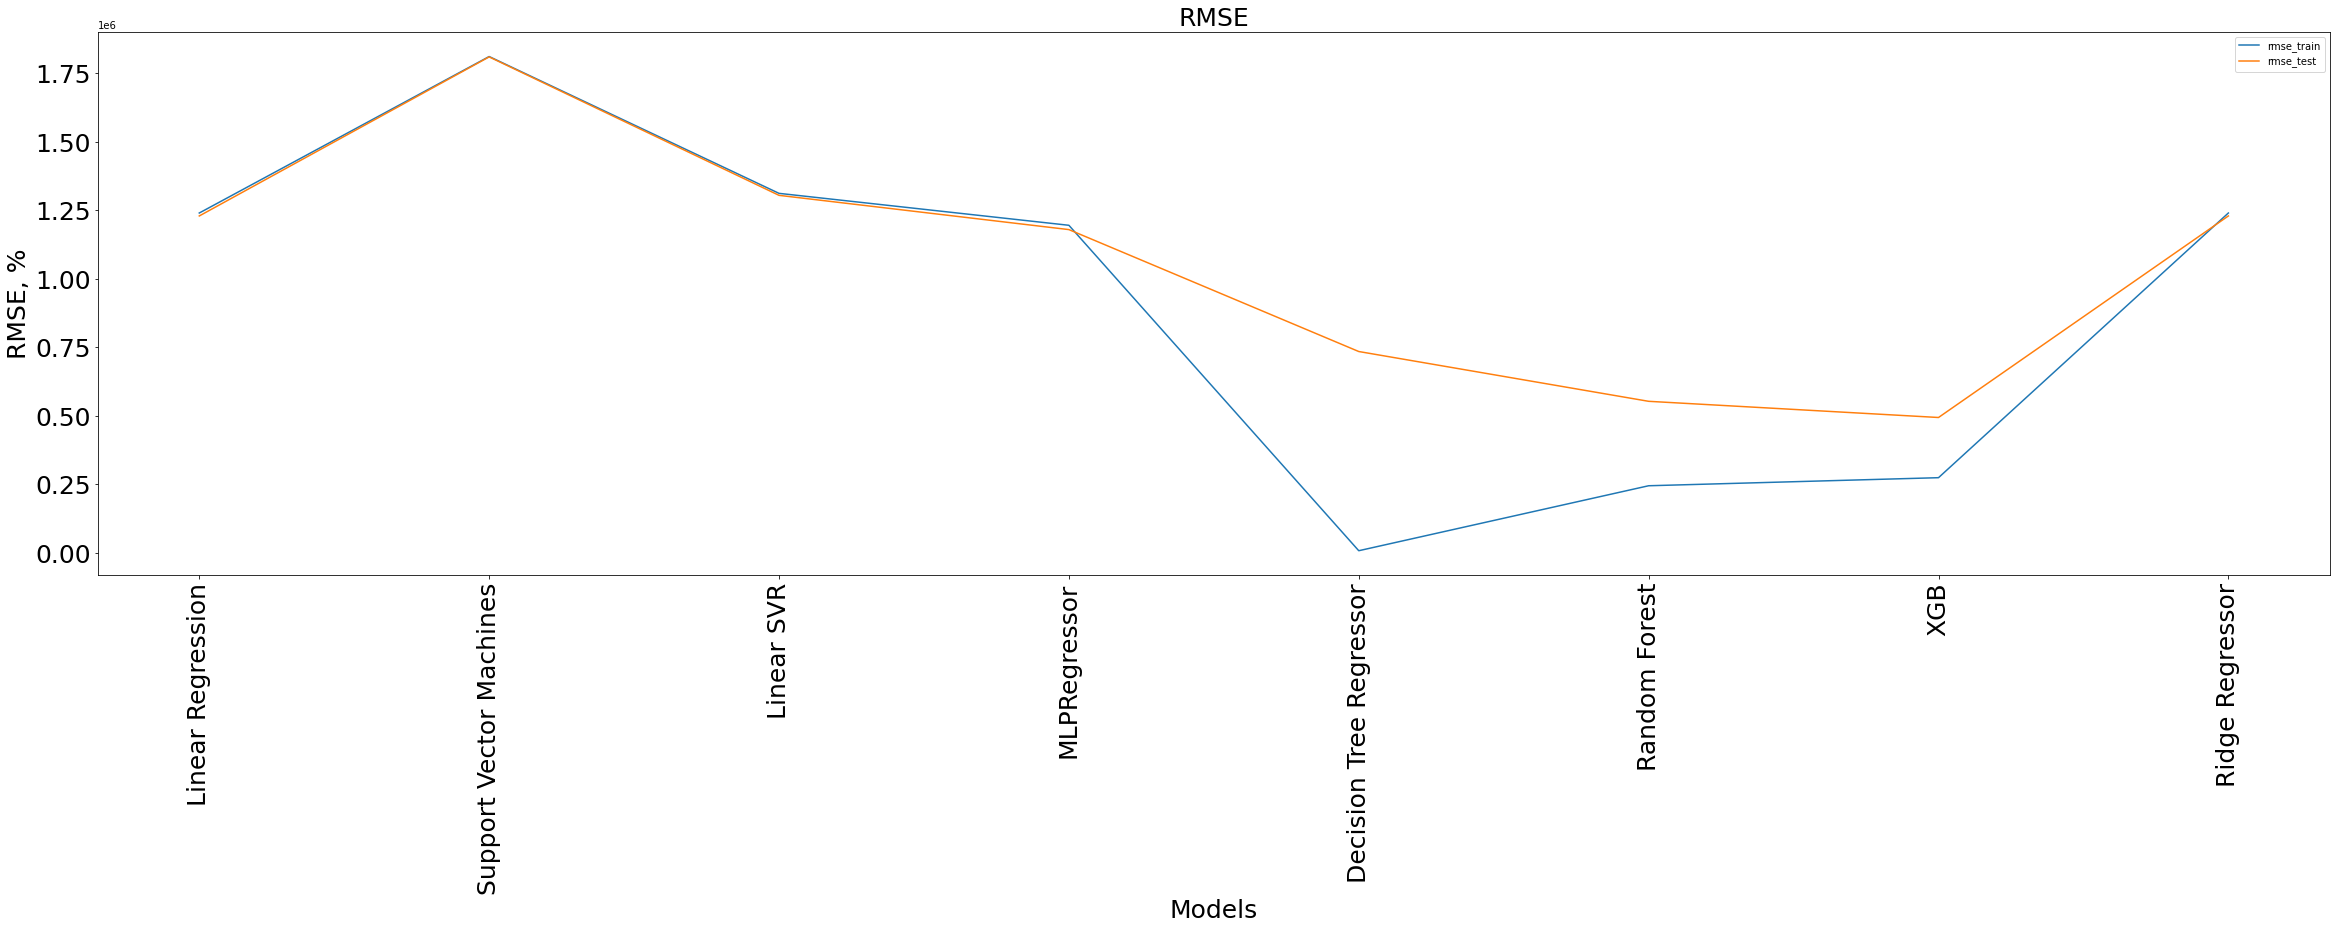

In [ ]:
# Plot
plt.figure(figsize=[40,10])
xx = models['Model']
plt.tick_params(labelsize=25)
plt.plot(xx, models['rmse_train'], label = 'rmse_train')
plt.plot(xx, models['rmse_test'], label = 'rmse_test')
plt.legend()
plt.title('RMSE', size=25)
plt.xlabel('Models', size=25)
plt.ylabel('RMSE, %', size=25)
plt.xticks(xx, rotation='vertical')
plt.show()

## 6.Prediction

In [ ]:
target_prediction = random_forest.predict(test)

In [129]:
df = {'y':target_test,'prediction':target_prediction}
df = pd.DataFrame(df)

Density plot showing the distribution of actual and predicted car prices

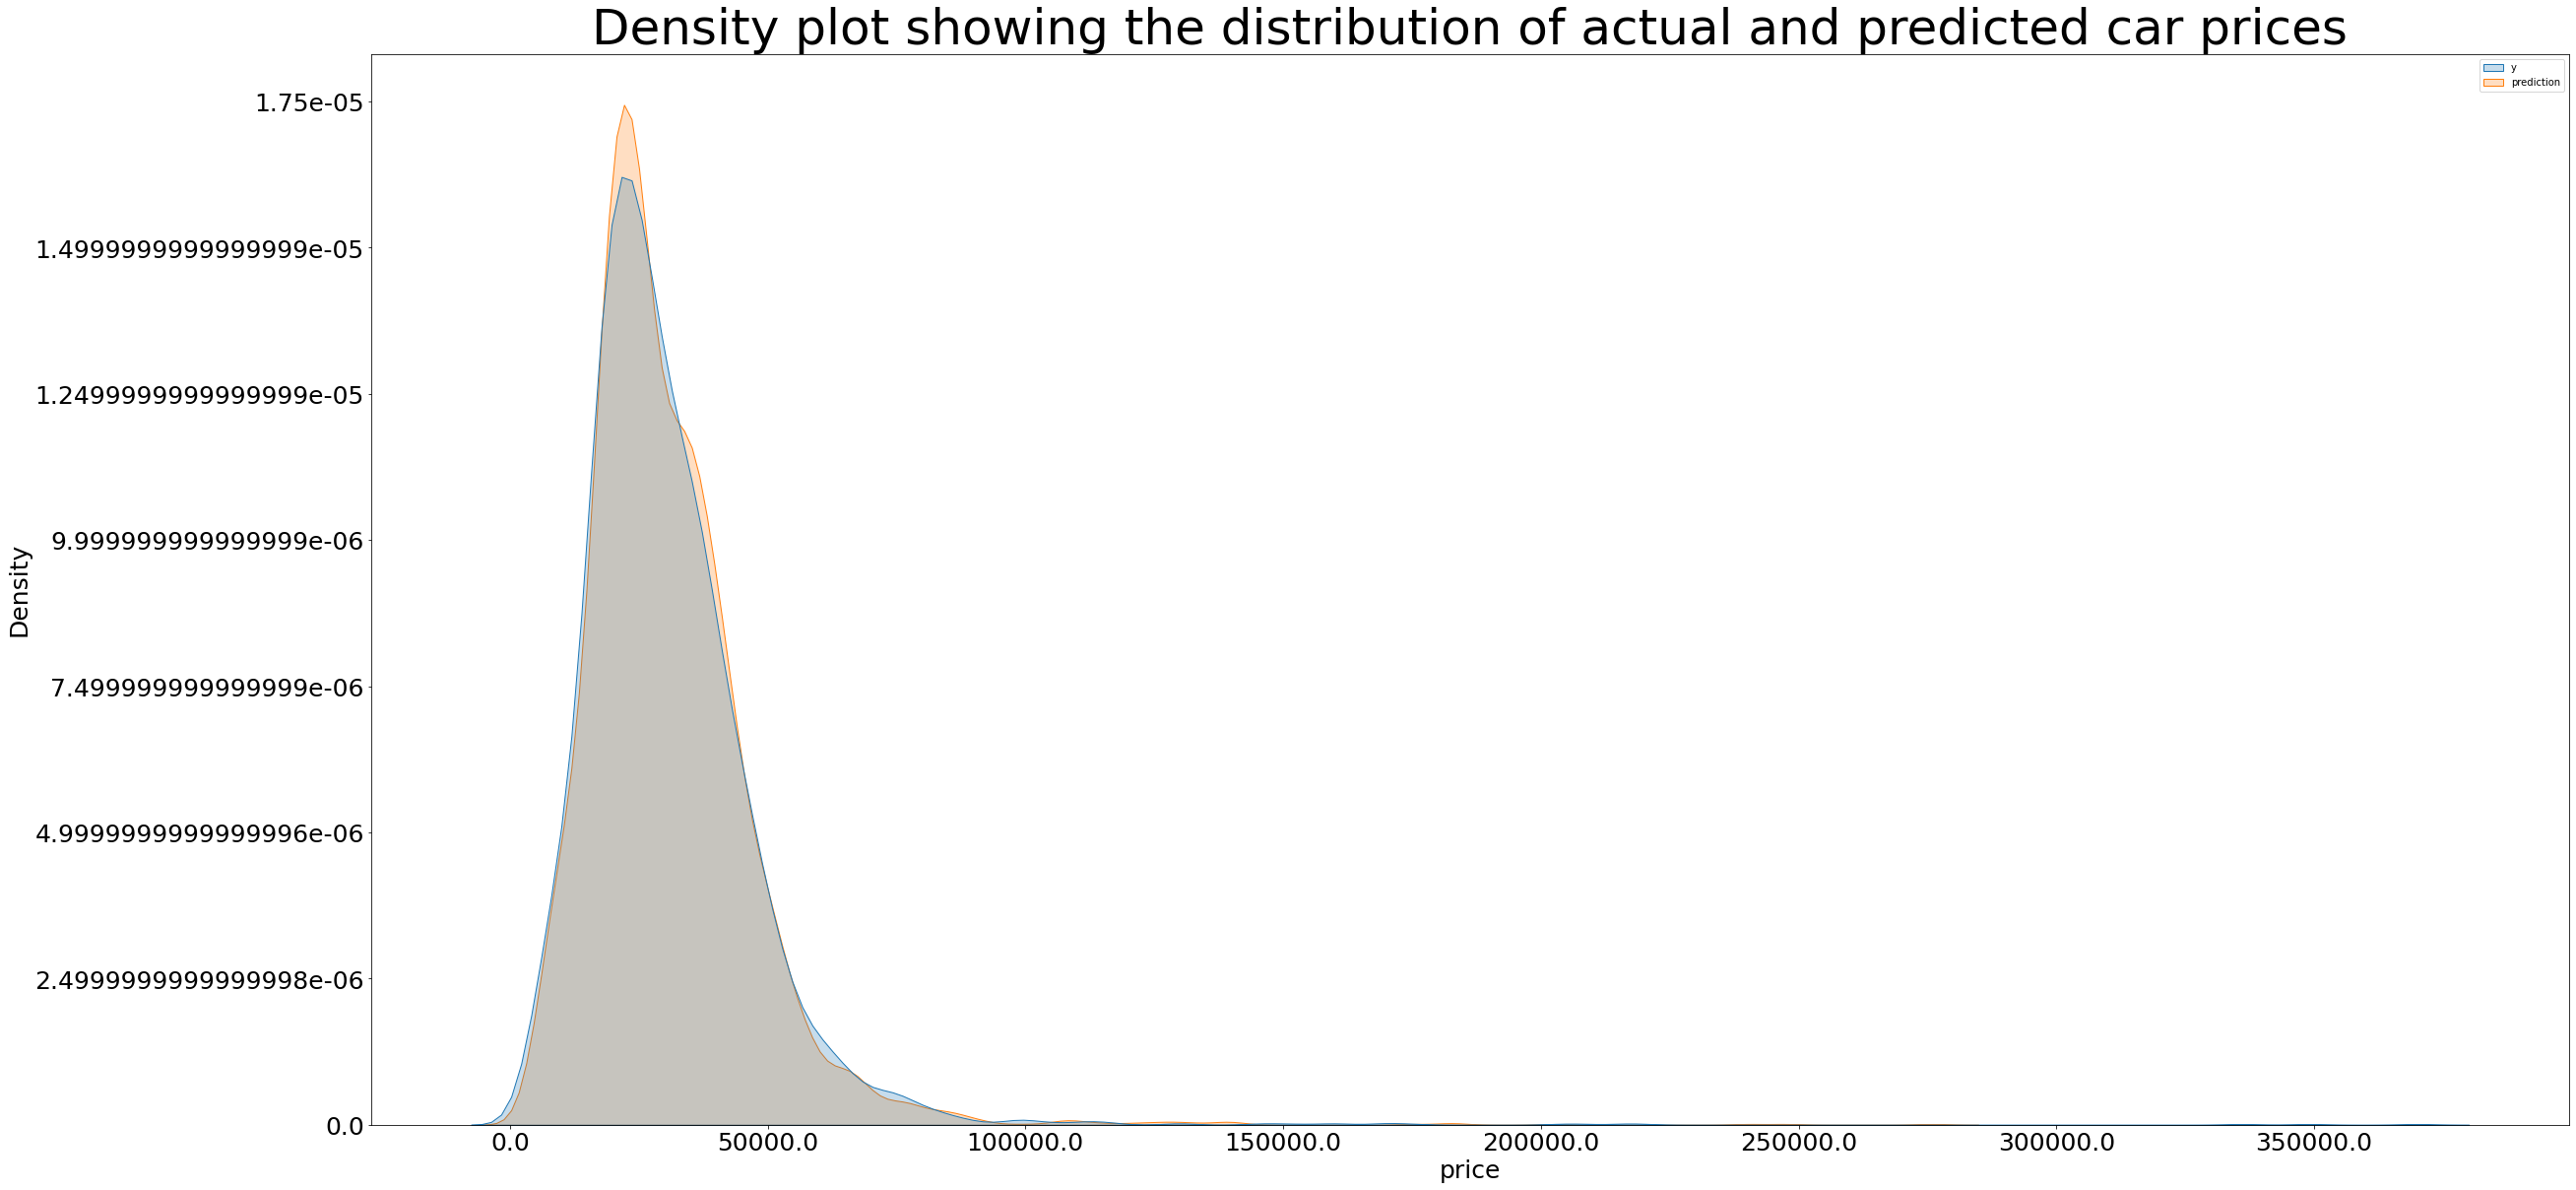

In [146]:
plt.figure(figsize=(40,20))
ax = sns.kdeplot(data=df, fill = 0.5)
ax.set_title("Density plot showing the distribution of actual and predicted car prices", size = 50)
ax.set_xticklabels(ax.get_xticks(), size = 25);
ax.set_yticklabels(ax.get_yticks(), size = 25)
ax.set_xlabel('price',fontsize=25);
ax.set_ylabel('Density',fontsize=25);